In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import jcl
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap

In [43]:
binned_spikes.shape

(98, 279)

In [ ]:
days = ['20220909','20220920']
day_num = {'20220920':11, '20220909':1,'20220910':2}
rats = ["JC283"]
maze_type = 'andrea'
clu_sampling = 20000
whl_sampling = 39.0625
time_bin = 1/whl_sampling # distance between each time stamp in whl (in ms)

whl_to_clu = clu_sampling/whl_sampling
time_bin_widths=[200,2000, 5000, 10000, 20000]
for time_width in time_bin_widths:
    for rat in rats:
        for day in days:
            path = "./m" + rat + "-" + day + "/"

            des_path = path + rat + "-" + day + '.des'
            with open(des_path, 'r') as file:
                des = np.array(file.read().split())
            bad_cells = []
            for cell_id in range(len(des)):
                if des[cell_id] != "pp":
                    bad_cells.append(cell_id) 
            CY=[]
            CN=[]
            SY=[]
            SN=[]
            behavior_df = pd.read_csv("./JC283_data.csv")
            behavior_df = behavior_df[behavior_df['Session_ID'] == day_num[day]].reset_index(drop =True)
            for index, row in behavior_df.iterrows():
                if row['Flavor'] == "C":
                    if row['Correct'] == "Y":
                        CY.append(index)
                    else:
                        CN.append(index)
                else:
                    if row['Correct'] == "Y":
                        SY.append(index)
                    else:
                        SN.append(index)
            trial_order = CY + CN + SY + SN
            type_ends = [len(CY), len(CN), len(SY), len(SN)]

            spike_matrix = []  
            trial_matrix = []
            trial_type_arr = []

            i=0
            for training_num in [1,2]:

                clu_path = path + rat + "-" + day + '_training' + str(training_num) + '.clu'
                res_path = path+ rat + "-" + day + '_training' + str(training_num) + '.res'
                trial_path = path + rat + "-" + day + '_training' + str(training_num) + '.trials'

                with open(trial_path,'r') as f:
                    for trial in f:
                        trial = np.array(trial.split(" "), dtype = int)

                        spike_times = jcl.load.spike_times_from_res_and_clu( 
                            res_path, clu_path, exclude_clusters=[0, 1],
                            ts_limits = ( trial[0]*whl_to_clu, trial[5]*whl_to_clu) ) 

                        binned_spikes = jcl.load.bins_from_spike_times(
                             spike_times, bin_len = time_width, return_mat_type = np.array )
                        trial_type_arr.append([behavior_df.iloc[i]['Flavor']]*binned_spikes.shape[1])
                        spike_matrix.append(binned_spikes)                  
                        trial_matrix.append( (trial - trial[0])*whl_to_clu )
                        i+=1
                    f.close()

            sorted_spike_matrix = []
            sorted_trial_matrix = []
            sorted_trial_type_arr = []
            for i in trial_order:
                sorted_spike_matrix.append(spike_matrix[i])
                sorted_trial_matrix.append(trial_matrix[i])
                sorted_trial_type_arr.append(trial_type_arr[i])

            pca_data = np.concatenate(sorted_spike_matrix, axis = 1)
            trial_types = np.concatenate(sorted_trial_type_arr)
            color = {'C':'red','S':'blue','H':'green'}
            pca_data = np.delete(pca_data, bad_cells, axis=0)
            print(pca_data.shape)

            row_means = np.mean(pca_data, axis=1)
            Z = (pca_data - row_means[:, np.newaxis]) 

            # 2. Calculate the Covariance Matrix
            covariance_matrix = np.cov(Z)
            # 3. Compute the Eigenvectors and Eigenvalues
            eigenvalues, eigenvector = np.linalg.eig(covariance_matrix)
            # 4. Sort Eigenvalues
            sorted_eigenvalues = np.sort(eigenvalues)[::-1]
            # 5. Calculate Variance Explained
            total_variance = np.sum(sorted_eigenvalues)
            variance_explained = sorted_eigenvalues / total_variance

            # 6. Visualize Variance Explained
            plt.figure(figsize = (6,3))
            plt.plot(np.cumsum(variance_explained), marker='o', linestyle='-')
            plt.xlabel('Number of Principal Components')
            plt.ylabel('Cumulative Variance Explained')
            plt.title('Variance Explained by Principal Components')
            plt.xlim([0,np.where(np.cumsum(variance_explained)>0.99)[0][0]])
            plt.title(rat + " day" + str(day_num[day]) + " " + "Start to Outer"+"  timebin"+str(time_width))
            plt.grid()
            plt.show()     

            pca = PCA(n_components= np.where(np.cumsum(variance_explained)>0.95)[0][1] )
            projected_data = pca.fit_transform(Z.T) 

            plt.figure(figsize = (6, 6), dpi = 50)
            plt.scatter(projected_data[:, 0], projected_data[:, 1] )
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.title('PCA Visualization of Neural Firing Rate Data')
            plt.show()

            reducer = umap.UMAP(n_components=2)  # Reduce to 2D for visualization
            embedding = reducer.fit_transform(Z.T)  # Transpose the data for UMAP

            # 3. Visualize the Reduced Data
            plt.scatter(embedding[:, 0], embedding[:, 1])
            plt.xlabel('UMAP Component 1')
            plt.ylabel('UMAP Component 2')
            plt.title('UMAP Visualization of Neural Firing Rate Data')
            plt.show()

(117, 4758)


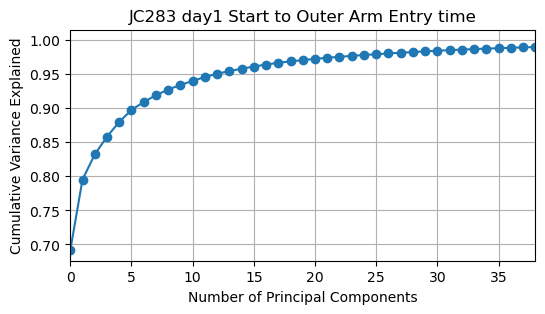

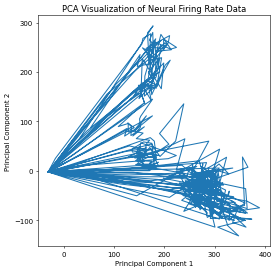

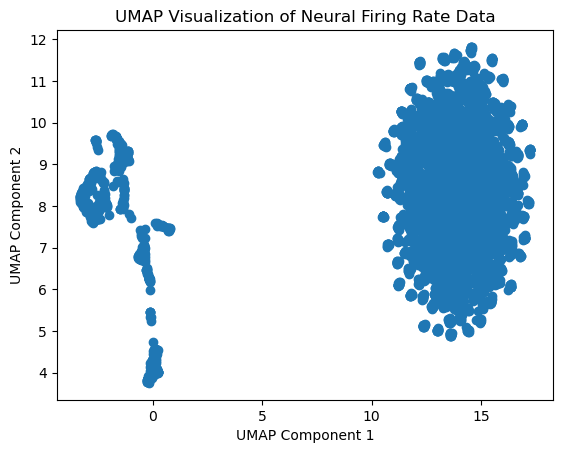

(69, 10095)


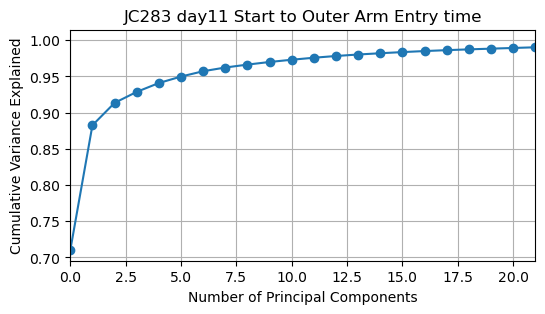

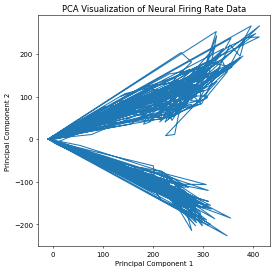

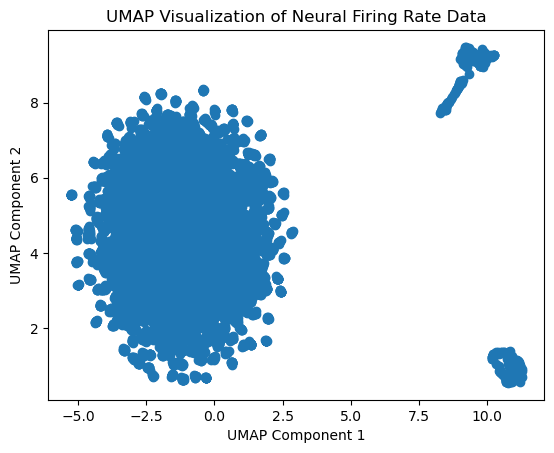

In [38]:
days = ['20220909','20220920']
day_num = {'20220920':11, '20220909':1,'20220910':2}
rats = ["JC283"]
maze_type = 'andrea'
clu_sampling = 20000
whl_sampling = 39.0625
time_bin = 1/whl_sampling # distance between each time stamp in whl (in ms)

whl_to_clu = clu_sampling/whl_sampling

for rat in rats:
    for day in days:
        path = "./m" + rat + "-" + day + "/"
        
        des_path = path + rat + "-" + day + '.des'
        with open(des_path, 'r') as file:
            des = np.array(file.read().split())
        bad_cells = []
        for cell_id in range(len(des)):
            if des[cell_id] != "pp":
                bad_cells.append(cell_id) 
        CY=[]
        CN=[]
        SY=[]
        SN=[]
        behavior_df = pd.read_csv("./JC283_data.csv")
        behavior_df = behavior_df[behavior_df['Session_ID'] == day_num[day]].reset_index(drop =True)
        for index, row in behavior_df.iterrows():
            if row['Flavor'] == "C":
                if row['Correct'] == "Y":
                    CY.append(index)
                else:
                    CN.append(index)
            else:
                if row['Correct'] == "Y":
                    SY.append(index)
                else:
                    SN.append(index)
        trial_order = CY + CN + SY + SN
        type_ends = [len(CY), len(CN), len(SY), len(SN)]
        
        spike_matrix = []  
        trial_matrix = []
        trial_type_arr = []
        for training_num in [1,2]:

            clu_path = path + rat + "-" + day + '_training' + str(training_num) + '.clu'
            res_path = path+ rat + "-" + day + '_training' + str(training_num) + '.res'
            trial_path = path + rat + "-" + day + '_training' + str(training_num) + '.trials'

            with open(trial_path,'r') as f:
                for trial in f:
                    trial = np.array(trial.split(" "), dtype = int)
                    
                    spike_times = jcl.load.spike_times_from_res_and_clu( 
                        res_path, clu_path, exclude_clusters=[0, 1],
                        ts_limits = ( trial[0]*whl_to_clu, trial[5]*whl_to_clu) ) 
                    
                    binned_spikes = jcl.load.bins_from_spike_times(
                         spike_times, bin_len = 10000, return_mat_type = np.array )
                    
#                     trial_type_arr.append([])                
                    
                    spike_matrix.append(binned_spikes)                  
                    trial_matrix.append( (trial - trial[0])*whl_to_clu )
                f.close()

        sorted_spike_matrix = []
        sorted_trial_matrix = []
        sorted_trial_type_arr = []
        for i in trial_order:
            sorted_spike_matrix.append(spike_matrix[i])
            sorted_trial_matrix.append(trial_matrix[i])

        pca_data = np.concatenate(sorted_spike_matrix, axis = 1)
        
        pca_data = np.delete(pca_data, bad_cells, axis=0)
        print(pca_data.shape)
        
        row_means = np.mean(pca_data, axis=1)
        Z = (pca_data - row_means[:, np.newaxis]) 

        # 2. Calculate the Covariance Matrix
        covariance_matrix = np.cov(Z)
        # 3. Compute the Eigenvectors and Eigenvalues
        eigenvalues, eigenvector = np.linalg.eig(covariance_matrix)
        # 4. Sort Eigenvalues
        sorted_eigenvalues = np.sort(eigenvalues)[::-1]
        # 5. Calculate Variance Explained
        total_variance = np.sum(sorted_eigenvalues)
        variance_explained = sorted_eigenvalues / total_variance

        # 6. Visualize Variance Explained
        plt.figure(figsize = (6,3))
        plt.plot(np.cumsum(variance_explained), marker='o', linestyle='-')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Variance Explained')
        plt.title('Variance Explained by Principal Components')
        plt.xlim([0,np.where(np.cumsum(variance_explained)>0.99)[0][0]])
        plt.title(rat + " day" + str(day_num[day]) + " " + "Start to Outer Arm Entry time")
        plt.grid()
        plt.show()     
        
        pca = PCA(n_components= np.where(np.cumsum(variance_explained)>0.95)[0][1] )
        projected_data = pca.fit_transform(Z.T) 

        plt.figure(figsize = (6, 6), dpi = 50)
        plt.scatter(projected_data[:, 0], projected_data[:, 1] )
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('PCA Visualization of Neural Firing Rate Data')
        plt.show()
        
        reducer = umap.UMAP(n_components=2)  # Reduce to 2D for visualization
        embedding = reducer.fit_transform(Z.T)  # Transpose the data for UMAP
        # 3. Visualize the Reduced Data
        plt.scatter(embedding[:, 0], embedding[:, 1])
        plt.xlabel('UMAP Component 1')
        plt.ylabel('UMAP Component 2')
        plt.title('UMAP Visualization of Neural Firing Rate Data')
        plt.show()